# Zillow Clustering Project
- **Saroj Duwal**
- **Kalpana Cohort**
- **08/17/2022**

# Goals
- The primary goal of this project is to improve original estimate of the log error by using clustering methodologies.
- And build a regression model to predict the log error

# Project Description

Zillow data for single family property with the transaction date in the year of 2017 will be analyzed and clustering methodologies will be used to predict the log error. Variety of unique regression model will be built based upon the best features. And finally, I would give some recommendations, next steps to take.

# Initial Questions
1. Is county(location) related to the logerror?
2. Is there any relation between log error and house price, yearbuilt?
3. Is there any relation between log error bead and bath ratio?
4. Why Orange county have high log error?


# Data Dictionary
- bedroom : Number of bedrooms in home.
- bathroom : Number of bathrooms
- parcelid : Unique identifier
- county : Federal Information Processing Standard code.
- yearbuilt: The Year house was built.
- finished_square_ft : Calculated total finished living area of the home.
- lot_square_ft : Area of the lot in square feet.
- house_value : The total tax assessed value of the property.
- structure_value : The assessed value of the built structure on the parcel.
- land_value : The assessed value of the land area of the parcel
- tax : The total property tax assessed for that assessment year.
- garage : Total number of garages on the lot including an attached garage.
- land_dollar_per_sqft : land taxvalue divided by lot size
- structure_dollar_per_sqft : structure taxvalue divided by square feet
- quality_type : Overall assessment of condition of the building from best (lowest) to worst (highest).
- latitude : Latitude of the middle of the parcel multiplied by 10e6.
- longitude : Longitude of the middle of the parcel multiplied by 10e6.
- city : City in which the property is located (if any).
- log_error : log error=log(Zestimate)−log(SalePrice). transaction_date : House transaction date.


# Data Acquisition

### Acquiring zillow data from CodeUp SQL database.
- I used the zillow database from Codeup DB server and selected bathroomcnt, bedroomcnt, basementsqft, parcelid, buildingqualitytypeid , calculatedfinishedsquarefeet, garagecarcnt,fips,longitude, latitude, lot size, regionid city,poolcnt, yearbuilt, structure value, land value, house value, log error , tax amount, transaction date from properties 2017 and join predictions 2017 table using parcelid.
- On a SQL query I made a filter to make sure that both longitude and latitude are not null and transaction date to be in the year 2017 only. Also filtered the data so that only single family property be listed.
            
            
            
            
             

In [2]:
#importing get_zillow_data from acquire module
from acquire import get_zillow_data


df=get_zillow_data()
df.head(2)

,bathroom,bedroom,basementsqft,parcelid,quality_type,finished_square_ft,garage,county,latitude,longitude,lot_square_ft,city,pool,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date
0,3.5,4.0,NaN,14297519,NaN,3100.0,2.0,6059.0,33634931.0,-117869207.0,4506.0,53571.0,NaN,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01
1,1.0,2.0,NaN,17052889,NaN,1465.0,1.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,NaN,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01


# Data Preparation
### To clean the data, I followed the following data cleansing process:
1. Drop all the duplicate parcelid and kept only the recent tranaction date parcelid.
2. Handled missing values by stating the threshold of proportion. I dropped the columns missing 60% and rows missing 75% data
3. convert the datatypes
4. Handled outliers  using IQR method
5. latitude and longitude converted
6. manually handled bedroom(<=6), bathroom(<=6) and house value(<2,500,000) by setting up the cut-off points
7. created new features 
      - yearbuilt: (2017-age)
      - bed and bath ratio: bathroom/bedroom
      - land_dollar_per_sqft= land_value/lot_square_ft
      - structure_dollar_per_sqft = structure_value/finished_square_ft
      - taxrate = tax/house_value * 100



In [3]:
# import prepare module
import prepare
import pandas as pd
pd.set_option('display.max_columns', None)

df= prepare.clean_zillow(df)
df.head(2)


,bathroom,bedroom,parcelid,quality_type,finished_square_ft,county,latitude,longitude,lot_square_ft,city,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date,age_bin,taxrate,bath_bed_ratio,land_tax_value_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin
1,1.0,2.0,17052889,NaN,1465.0,Ventura,34.449266,-119.281531,12647.0,13091.0,50.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01,40-50,1.222517,0.500000,"$450,000",60.068259,0.2,29.730371,20-49
2,2.0,3.0,14186244,NaN,1243.0,Orange,33.886168,-117.823170,8432.0,21412.0,55.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01,50-60,1.148823,0.666667,"$650,000",68.615447,0.2,56.865394,50-99


# Split the Data
- Data was split into train, validate and test sample.
- Exploration was done on train sample.
- Train Sample used to fit to the models while validate sample was used to verify the models built are not over and underfit
- Test sample was used on best performing model.

In [4]:
# importing split data function prepare module and split data into 3 samples
# split data function returns train, validate, test, x_train,y_train, x_validate,y_validate, x_test, y_test

train, validate, test= prepare.split_data(df)
print(f'Train shape{train.shape}\nValidate shape{validate.shape}\nTest shape{test.shape}')


Train shape(22566, 25)
Validate shape(9672, 25)
Test shape(8060, 25)


In [5]:
# Import all the libraries needed for the  exploration and modeling
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")



# Exploratory Analysis
- There are 52441 observations

Text(0.5, 0, 'Log Error')

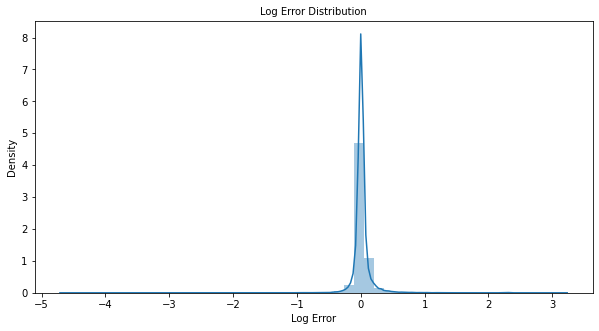

In [6]:
# visualizing the log error distribution
plt.figure(figsize=(10,5))
sns.distplot(df.log_error)
plt.title('Log Error Distribution', fontsize=10)
plt.xlabel('Log Error')

In [7]:
#Imputing missing values in train, validate and test  sample
# prepare module have imputing function
train = prepare.impute_missing_value_zillow(train)
validate = prepare.impute_missing_value_zillow(validate)
test = prepare.impute_missing_value_zillow(test)

## Question 1
## Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?


Text(0.5, 1.0, 'County vs Log Error')

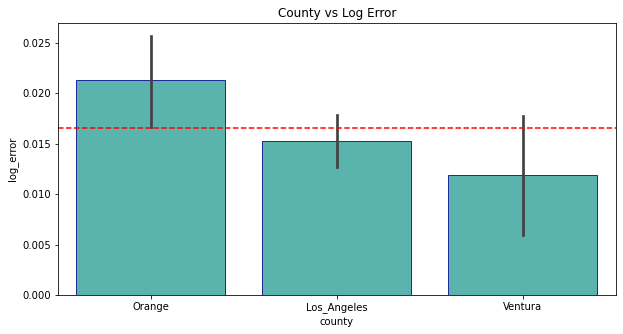

In [8]:
plt.figure(figsize=(10,5))
sns.barplot(train.county, train.log_error, data=train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = train.log_error.mean()
plt.axhline(overall_rate, ls='--', color='red', )
plt.title('County vs Log Error')

#### Hypothesis Testing - ANOVA
- $H_o$: There is no significant difference in logerror for properties in LA County vs Orange County vs Ventura County. 
- $H_a$: Logerror is significantly different among the counties of LA County, Orange County and Ventura County.

In [9]:
# setting alpha confidence level
α = 0.05
F, p = stats.f_oneway(train.log_error[train.county == 'Orange'], train.log_error[train.county == 'Los_Angeles'], train.log_error[train.county == 'Ventura'])
F, p

null_hypothesis = 'there is no significant difference in logerror for properties in LA County vs Orange County vs Ventura County'

if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We reject the null hypothesis that there is no significant difference in logerror for properties in LA County vs Orange County vs Ventura County


### Takeaways from Question 1
- There is a correlation  between the county zipcode and the log error.

## Question no 2. Does house price have influence in driving up the logerror in Orange county?

<AxesSubplot:xlabel='county', ylabel='house_value'>

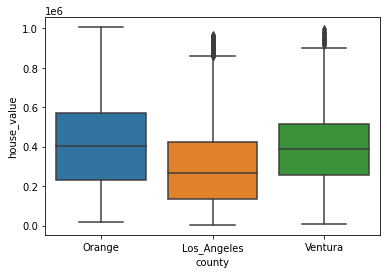

In [10]:
sns.boxplot(data = train, x='county', y='house_value')

### statistical test
-$H_0$ : Orange couty house price is <= average house price

-$H_a$: Orange county house price is > average house price

alpha = 0.05

In [11]:
α= 0.05
t_orangecounty_house_value, p_orangecounty_house_value= stats.ttest_1samp(train[train['county'] == 'Orange'].house_value,
                                 train['house_value'].mean())

if (p_orangecounty_house_value/2 < α) & (t_orangecounty_house_value > 0):
    print('We reject the null hypothesis. Orange county average house price is >  average house price.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Orange county average house price is >  average house price.


### Takeaways from Question2
- Orange county home value is greater than the average home value

## Question No.3
## Is there a relation between age of the house and log error

<AxesSubplot:xlabel='yearbuilt', ylabel='log_error'>

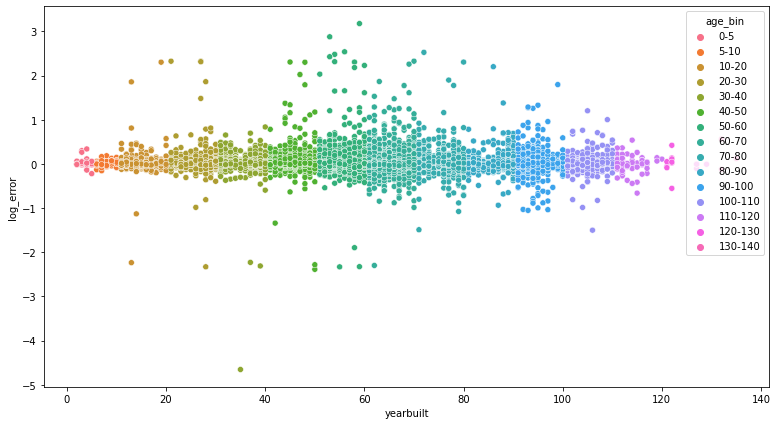

In [12]:
plt.figure(figsize=(13, 7))
sns.scatterplot(x='yearbuilt', y='log_error', data=train, hue='age_bin')

### hypothesis
-$H_0$ : There is no significant difference in logerror for the age of the house

-$H_a$: There is significant difference in logerror for the age of the house

alpha = 0.05



In [13]:
# running a statistics testing
corr, p = stats.pearsonr(train.yearbuilt, train.log_error)

if p < α:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We fail to reject the null hypothesis.


### Takeaways from Question 3
- age of the property and log error are correlated

## Question no. 4
## Is there relation between land_dollar_per_sqft and log error?

Text(0.5, 1.0, 'Lot Dollar Per Square Footage v. Log Error')

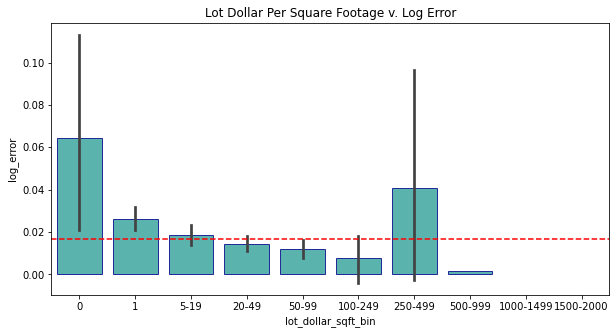

In [14]:
plt.figure(figsize=(10,5))
sns.barplot(train.lot_dollar_sqft_bin, train.log_error, data=train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = train.log_error.mean()
plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Lot Dollar Per Square Footage v. Log Error')

### hypothesis
-$H_0$ : There is no significant difference in logerror for the age of the house

-$H_a$: There is significant difference in logerror for the age of the house

alpha = 0.05

In [15]:
# running stats test
corr, p = stats.pearsonr(train.land_dollar_per_sqft, train.log_error)

if p < α:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### takeaway from question 4
- We failed to deny that there is no correlation between land_dollar_per_sqft and log error

## Qustion no.5  Realtion between log error and  bath and bed ratio?

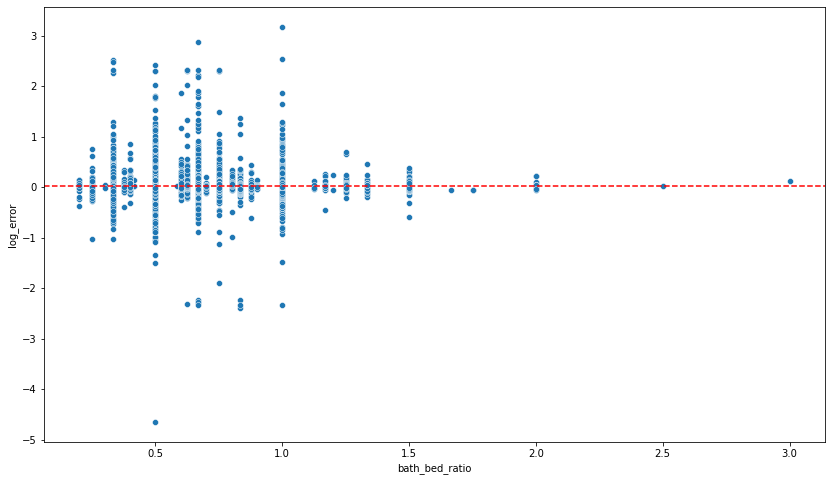

In [16]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='bath_bed_ratio', y='log_error', data=train)
overall_rate = train.log_error.mean()
plt.axhline(overall_rate, ls='--', color='red', )

-$H_0$ : There is no significant difference in logerror for the bath and bed ratio

-$H_a$: There is significant difference in logerror for the bath and bed ratio

α = 0.05



In [17]:

corr, p = stats.pearsonr(train.bath_bed_ratio, train.log_error)

if p < α:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We fail to reject the null hypothesis.


## Question 6 : Is there a correlartion between house price and logerror?

<AxesSubplot:xlabel='house_value', ylabel='log_error'>

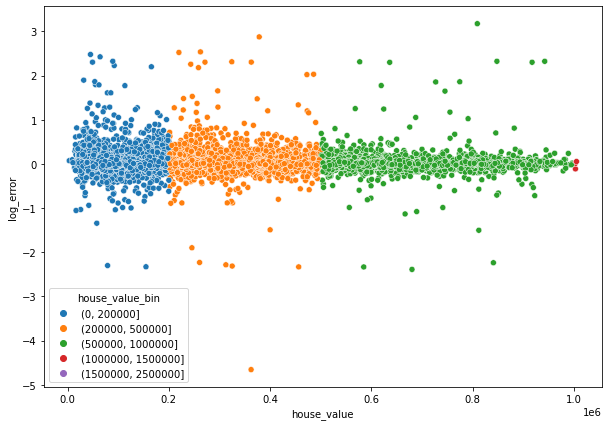

In [18]:
# bin the house values
train['house_value_bin'] = pd.cut(train.house_value, [0, 200_000, 500_000, 100_0000,150_0000,250_0000])

# plot 
plt.figure(figsize=(10, 7))
sns.scatterplot(x='house_value', y='log_error', data=train, hue='house_value_bin')

-$H_0$ : There is no significant difference in logerror for the price of the house

-$H_a$: There is significant difference in logerror for the price of the house

alpha = 0.05



In [19]:
alpha = 0.05

corr, p = stats.pearsonr(train.house_value, train.log_error)

if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null.")

We reject the null hypothesis.


### Takeaways from from question 5 and 6
- House price and log error are correlated
- log error and bed and bath ratio are correlated

<AxesSubplot:>

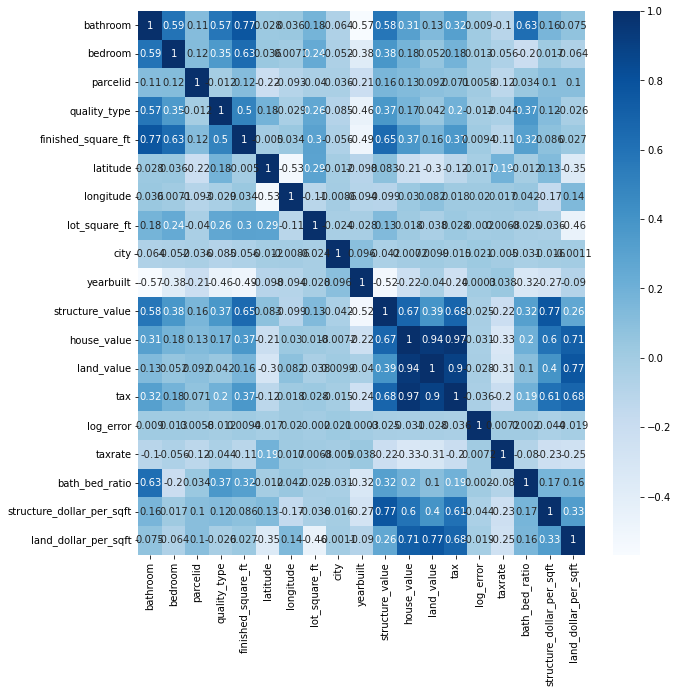

In [20]:
#heat map for correlation
plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

# Clustering


From the xy_split function we  have:
- x_train and y_train
- x_validate and y_validate 
- x_test  and y_test

In [21]:
# split the data to x and y (train, validate and test)
x_train,y_train, x_validate,y_validate, x_test, y_test = prepare.xy_split(train, validate, test)


In [22]:
#scale the data using minmax scaler using the scale data function from prepare module

x_train_scaled, x_validate_scaled, x_test_scaled, y_train, y_validate, y_test, x_unscaled = prepare.scaled_data(x_train, x_validate, x_test, y_train, y_validate, y_test)

In [23]:
# need to make dummy columns for county code and add it to scaled dataframe
county_dummies_train = pd.get_dummies(train['county']) 
county_dummies_validate = pd.get_dummies(validate['county'])
county_dummies_test = pd.get_dummies(test['county'])

# concatenate it to scaled dataframe
X_train_scaled = pd.concat([x_train_scaled,county_dummies_train],axis=1)
X_validate_scaled = pd.concat([x_validate_scaled,county_dummies_validate],axis=1)
X_test_scaled = pd.concat([x_test_scaled,county_dummies_test],axis=1)

#  Cluster on Location  using latitude,longitude and county

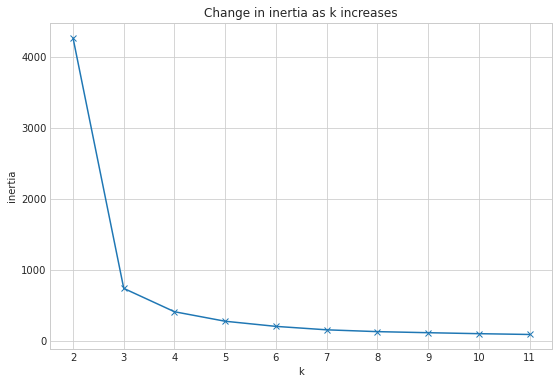

In [24]:
# make a cluster using features selected
X1 = X_train_scaled[['latitude', 'longitude', 'Los_Angeles','Orange','Ventura']]

# elbow method to find value of k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X1).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

- from the elbow graph **k=3**

In [25]:
#  Make the kmeans object
kmeans = KMeans(n_clusters=3)

# fit the kmeans model
kmeans.fit(X1)

# use the thing
location=kmeans.predict(X1)
location

array([1, 1, 0, ..., 1, 1, 0], dtype=int32)

In [26]:
# create a column for the cluster created in the scaled dataframe
X_train_scaled['location'] = location
X_train_scaled.head(2)

,finished_square_ft,latitude,longitude,lot_square_ft,bedroom,bathroom,structure_dollar_per_sqft,structure_value,house_value,land_value,yearbuilt,bath_bed_ratio,land_dollar_per_sqft,Los_Angeles,Orange,Ventura,location
14844,0.561946,0.168161,0.850746,0.650973,0.6,0.3,0.079283,0.213794,0.134232,0.072172,0.338346,0.151786,0.011283,0,1,0,1
43572,0.460372,0.065976,0.927257,0.299363,0.4,0.3,0.305192,0.697690,0.919854,0.885906,0.195489,0.226190,0.277857,0,1,0,1


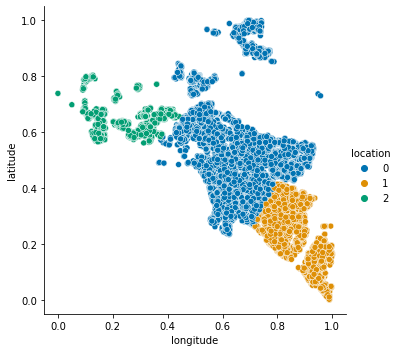

In [27]:
sns.relplot(x="longitude", y="latitude", hue="location", data=X_train_scaled,palette='colorblind')

###  Setting up Hypothesis and run a statistical test on Location cluster

- $𝐻_0$ : There is no difference in log error between cluster 1 and cluster 0.

- $𝐻_𝑎$: There is a difference in log error between cluster 1 and cluster 0.

In [28]:
# create a dataframe with the location cluster column and logerror
location_cluster_log_error= pd.DataFrame({'log_error': y_train.log_error})
location_cluster_log_error['location']= location

In [29]:
t_location_cluster, p_location_cluster = stats.ttest_ind(location_cluster_log_error[location_cluster_log_error['location'] == 1].log_error, 
                                                         location_cluster_log_error[location_cluster_log_error['location'] == 0].log_error)

alpha = 0.05

if p_location_cluster < alpha:
    print('We reject the null hypothesis. There is a difference in log error between cluster 1 and cluster 0')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. There is a difference in log error between cluster 1 and cluster 0


# Cluster on value (structure_value, land_value, house_value)

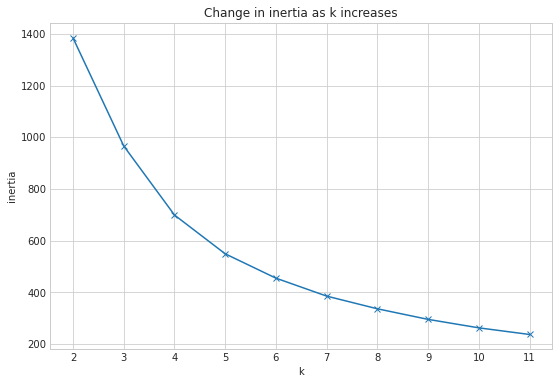

In [30]:
value= X_train_scaled[['structure_value', 'house_value','land_value']]

# plot to find the best k value using elbow method
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(value).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

- from the graph of elbow method **k=4**

In [31]:
# create and fit kmeans
kmeans3 = KMeans(n_clusters=4)
kmeans3.fit(value)

cluster_value = kmeans3.predict(value)
cluster_value

array([2, 3, 0, ..., 1, 2, 2], dtype=int32)

In [32]:
# add the cluster value column to dataframe
X_train_scaled['cluster_value'] = cluster_value

In [33]:
# make a dataframe with logerror and cluster_value columns
cluster_value_logerror = pd.DataFrame({'log_error': y_train.log_error})
cluster_value_logerror['cluster_value'] = cluster_value

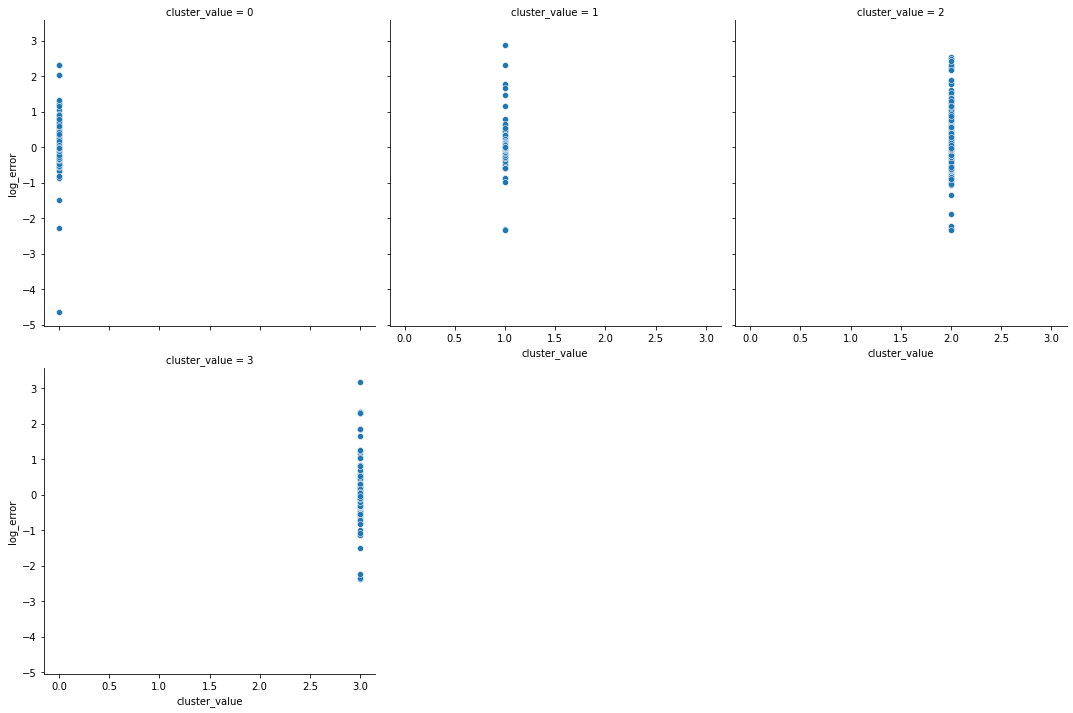

In [34]:
sns.relplot(data=cluster_value_logerror, x="cluster_value", y="log_error", col="cluster_value", col_wrap=3)

# Hypothesis and statistical test

- $𝐻_0$ : There is no difference in log error between cluster 0 and cluster 1.

- $𝐻_a$: There is a difference in log error between cluster 0 and cluster 1.

In [35]:
t_price_cluster, p_price_cluster = stats.ttest_ind(cluster_value_logerror[cluster_value_logerror['cluster_value'] == 0].log_error, 
                                                   cluster_value_logerror[cluster_value_logerror['cluster_value'] == 1].log_error)

alpha = 0.05

if p_price_cluster < alpha:
    print('We reject the null hypothesis. There is a difference in log error between cluster 0 and cluster 1.')
else:
    print('We fail to reject the null hypothesis.')

We fail to reject the null hypothesis.


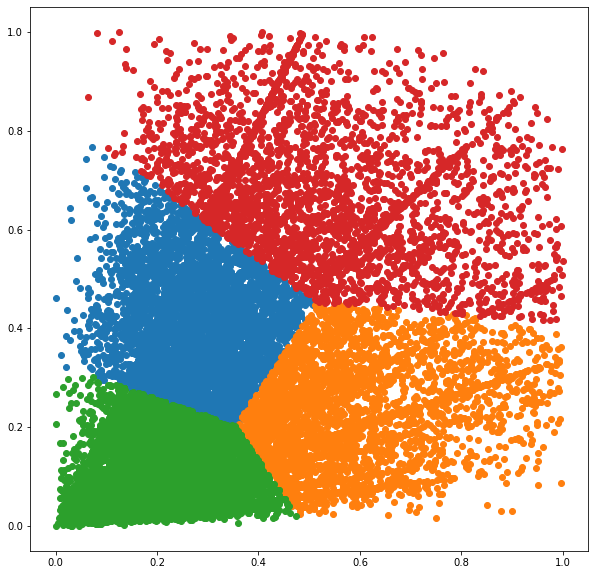

In [36]:
plt.figure(figsize=(10, 10))

for cluster_n in X_train_scaled.cluster_value.sort_values().unique():
    plt.scatter(X_train_scaled[X_train_scaled.cluster_value == 
                                          cluster_n].structure_value, 
                X_train_scaled[X_train_scaled.cluster_value == cluster_n].land_value, 
                label=f'cluster_{cluster_n}')



# Cluster miscellneous using year_built,bath_bed_ratio, land_dollar_per_sqft, structure_dollar_per_sqft

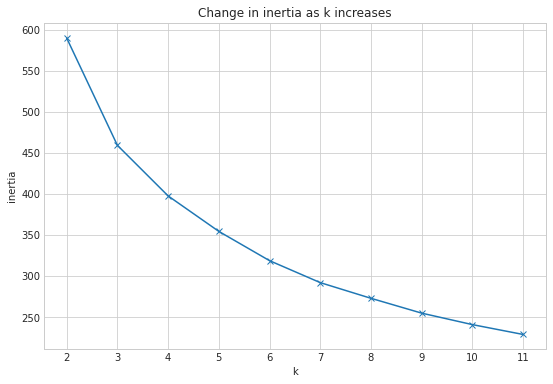

In [37]:
misc= X_train_scaled[['yearbuilt', 'land_dollar_per_sqft', 'structure_dollar_per_sqft','bath_bed_ratio' ]]


with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(misc).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### K= 3

In [38]:
kmeans3 = KMeans(n_clusters=3)
kmeans3.fit(misc)

cluster_misc = kmeans3.predict(misc)
cluster_misc

array([0, 2, 0, ..., 0, 0, 0], dtype=int32)

In [39]:
X_train_scaled['cluster_misce'] = cluster_misc

#make a dataframe with logerror and cluster misc
cluster3= pd.DataFrame({'log_error': y_train.log_error})
cluster3['cluster_misc']= cluster_misc

### Hypothesis Testing
𝐻0 : There is no difference in log error between cluster 0 and cluster 1.

𝐻𝑎: There is a difference in log error between cluster 0 and cluster 1.

In [40]:
t_misc, p_misc= stats.ttest_ind(cluster3[cluster3['cluster_misc']== 0].log_error,
                                cluster3[cluster3['cluster_misc']== 1].log_error)

alpha =0.05

if p_misc < alpha:
    print('We reject the null hypothesis. There is a difference in log error between cluster 0 and cluster 1')
else:
    print('We fail to reject the null hypothesis.')



We reject the null hypothesis. There is a difference in log error between cluster 0 and cluster 1


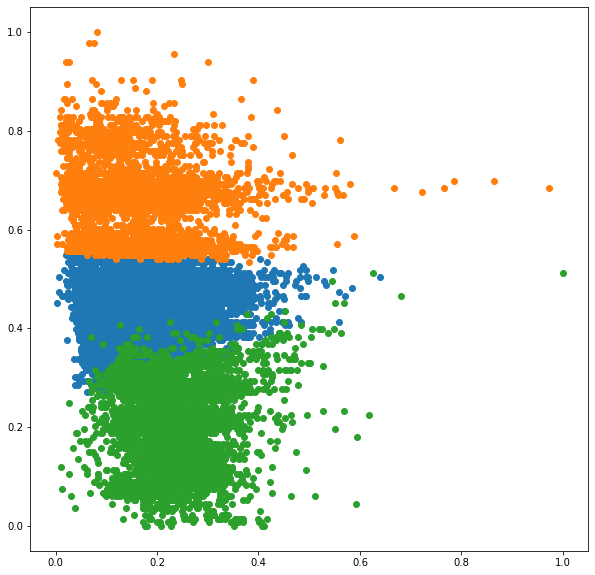

In [41]:
plt.figure(figsize=(10, 10))

for cluster_n in X_train_scaled.cluster_misce.sort_values().unique():
    plt.scatter(X_train_scaled[X_train_scaled.cluster_misce == 
                                          cluster_n].structure_dollar_per_sqft, 
                X_train_scaled[X_train_scaled.cluster_misce == cluster_n].yearbuilt, 
                label=f'cluster_{cluster_n}')

# Feature Engineering

In [42]:
## importing functions from prepare module for  RFE feature selection
features= prepare.select_kbest(X_train_scaled, y_train, 5)
features

['longitude',
 'structure_dollar_per_sqft',
 'structure_value',
 'house_value',
 'land_value']

In [54]:
# feature selection using select k best method
# import selectkbest function from prepare module
features1=prepare.rfe1(X_train_scaled, y_train,5)
features1

['longitude',
 'bedroom',
 'bathroom',
 'structure_dollar_per_sqft',
 'bath_bed_ratio']

- #### from the exploration and evaluation performed in workbook notebook,  RFE method performed better than select K best. Hence I used RFE selected features for modeling.

# Modeling

- **Since the target variable "Log Error" is a continous variable, Regression ML model will be created. And train data sample will be fitted to the models while validate sample will be used to verify the performance and test sample was used on the best performing model.**
- **Root Mean Squared Error (RMSE) was a chosen metrics for comparing the performance and comparing it to the baseline model. Smaller the RMSE score better the model performance.**

- **Features selected from RFE selection:**
        1. "longitude" 
        2. "bedroom"
        3. "bathroom" 
        4. "structure_dollar_per_sqft"
        5. "bath_bed_ratio"
  


### Setting up Baseline

In [45]:
# mean of logerror as the baseline
baseline = train.log_error.mean()

# setting up baselines for train and validate samples
train['baseline'] = baseline
validate['baseline'] = baseline

# RMSE for train and validate  baseline
train_rmse = sqrt(mean_squared_error(train.log_error, train.baseline))
validate_rmse = sqrt(mean_squared_error(validate.log_error, validate.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))

Train baseline RMSE: 0.16038712270931066.
Validation baseline RMSE: 0.16086423042849432.


## Fit Models
- features selected by **RFE** method 

### Models
    1. Linear Regression
    2. Lasso- Lars
    3. TweedieRegressor
    4. 2nd Degree polynomial
    5. Interaction only Polynomial

In [47]:
x_train_rfe = X_train_scaled[['bedroom',
 'bathroom',
 'structure_dollar_per_sqft',
 'land_value',
 'bath_bed_ratio']]


predictions_train_rfe_model = pd.DataFrame({'actual': train.log_error})
predictions_train_rfe_model['baseline'] = baseline

lm = LinearRegression()
lm.fit(x_train_rfe, y_train)
predictions_train_rfe_model['lm'] = lm.predict(x_train_rfe)

lars = LassoLars(alpha=1.0)
lars.fit(x_train_rfe, y_train)
predictions_train_rfe_model['lasso_lars'] = lars.predict(x_train_rfe)

glm = TweedieRegressor(power=0, alpha=1)
glm.fit(x_train_rfe, y_train)
predictions_train_rfe_model['glm'] = glm.predict(x_train_rfe)

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(x_train_rfe)
x_train_rfe_poly = pd.DataFrame(
    poly.transform(x_train_rfe),
    columns=poly.get_feature_names(x_train_rfe.columns),
    index=train.index)
lm1 = LinearRegression()
lm1.fit(x_train_rfe_poly, y_train)
x_train_poly = poly.transform(x_train_rfe)
predictions_train_rfe_model['polynomial_degree_2'] = lm1.predict(x_train_rfe_poly)

poly1 = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly1.fit(x_train_rfe)
x_train_rfe_poly1 = pd.DataFrame(
    poly1.transform(x_train_rfe),
    columns=poly1.get_feature_names(x_train_rfe.columns),
    index=train.index)
lm1.fit(x_train_rfe_poly1, y_train)
x_train_poly1 = poly1.transform(x_train_rfe)
predictions_train_rfe_model['polynomial_only_interaction'] = lm1.predict(x_train_rfe_poly1)
predictions_train_rfe_model.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2,polynomial_only_interaction
14844,-0.013522,0.016592,0.028347,0.016592,0.016912,0.024175,0.024013
43572,0.085926,0.016592,0.001518,0.016592,0.015926,-0.000967,0.003762
17055,0.010107,0.016592,0.012466,0.016592,0.016469,0.009716,0.009690
7546,0.085135,0.016592,0.016041,0.016592,0.016558,0.013610,0.013361
6558,-0.015197,0.016592,0.015664,0.016592,0.016536,0.014360,0.013356


In [48]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_train_rfe_model.actual, y_predicted))
predictions_train_rfe_model.apply(calculate_rmse).sort_values()

actual                         0.000000
polynomial_degree_2            0.159997
polynomial_only_interaction    0.160017
lm                             0.160188
glm                            0.160378
baseline                       0.160387
lasso_lars                     0.160387
dtype: float64

#### from the RMSE score linear regreesion, 2nd degree polynomial and interaction only polynomial are the top 3 performing models. So validation will be carried on these 3 models.

In [50]:
#  the validate sample
x_validate_rfe = X_validate_scaled[['bedroom','bathroom','structure_dollar_per_sqft','land_value','bath_bed_ratio']]
predictions_validate_rfe_model = pd.DataFrame({'actual': validate.log_error})

lm.fit(x_train_rfe, y_train)
predictions_validate_rfe_model['lm'] = lm.predict(x_validate_rfe)

lm1 = LinearRegression()
lm1.fit(x_train_rfe_poly, y_train)
predictions_validate_rfe_model['polynomial_degree_2'] = lm1.predict(poly.transform(x_validate_rfe))

lm1.fit(x_train_rfe_poly1, y_train)
predictions_validate_rfe_model['polynomial_only_interaction'] = lm1.predict(poly1.transform(x_validate_rfe))
predictions_validate_rfe_model.head()

,actual,lm,polynomial_degree_2,polynomial_only_interaction
1103,0.037393,0.020523,0.013716,0.014517
7910,0.004254,0.017595,0.022763,0.021916
1339,0.005471,0.007768,0.007771,0.005608
45475,-0.006522,0.012451,0.007505,0.007415
105,0.007143,0.024152,0.022374,0.021033


In [51]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_validate_rfe_model.actual, y_predicted))
predictions_validate_rfe_model.apply(calculate_rmse).sort_values()

actual                         0.000000
lm                             0.160502
polynomial_only_interaction    0.160557
polynomial_degree_2            0.160598
dtype: float64

### Observation made from RMSE score of validation set
- Linear regression performed better than other two models

In [76]:
# fit the best model on test set i.e linear regression
x_test_rfe = X_test_scaled[['bedroom','bathroom','structure_dollar_per_sqft','land_value','bath_bed_ratio']]
lm_test_rfe = LinearRegression()
lm_test_rfe.fit(x_train_rfe, y_train)

LinearRegression()

In [77]:
test_prediction = lm.predict(x_test_rfe)
rmse = sqrt(mean_squared_error(y_test,test_prediction))
print(f'test RMSE {rmse}')

test RMSE 0.17225323653500227


### The best performing model  linear regression model did not beat the baseline.
- Linear Regression RMSE for Test sample: 0.1723 while the baseline model has RMSE of 0.16. 



# Conclusion
 
## Summary
- Three different clusters (location, value and miscellenous) were created. Bedroom,Bathroom,structure_dollar_per_sqft,land_value,bath_bed_ratio were top five features using Recursive Feature Elimination method which were used to predict the log error. However, the best model with RMSE of 0.17 didnot beat the baseline RMSE of 0.16
- Accoring to the test result we can expect log error of 0.172 in future unseen data.



# Recommendations
- None of the clusters created were best features according to RFE method. So more clusters could be explored using different features in the future.



# Next Steps
- I would take different approach in creating the clusters.
- Changing some parameters in the models used could have resulted in better performance. So I would try tweaking the parameters in the model.